<a href="https://colab.research.google.com/github/EVA4-RS-Group/Phase2/blob/master/S2_mobilenet_v2_custom_dataset/Training/EVA4_S2_mobilnet_v2_transfer_learning_v6B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Loading standard Libraries and project modules

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Load modules/models from EVA course
!rm -rf Modules
!git clone https://github.com/EVA4-RS-Group/Phase2 -q --quiet
!mv ./Phase2/Modules ./Modules
!rm -rf Phase2
#print("Loaded EVA4 Modules")
from Modules import *

# 2. Load Data & Set Data Loaders

In [3]:
# Downloading dataset and unziping into proper folder structure
!rm -rf final_images
!wget -q https://github.com/EVA4-RS-Group/Phase2/releases/download/s2/final_images_ver2.zip
!unzip -q final_images_ver2.zip
!mv /content/final_images_ver2 /content/final_images
!rm -rf /content/__MACOSX
!find /content/final_images -name '.DS_Store' -type f -delete

## 2.1 Calculate mean and standard deviation for the data

In [4]:
find_mean_standard_deviation("/content/final_images/")

Sub-folders: ['Winged Drones', 'Flying Birds', 'Small QuadCopters', 'Large QuadCopters']
Mean: [0.53614524 0.58885578 0.62041911]
Std: [0.27362225 0.25486343 0.2974289 ]
Processing completed in 1m 40s


## 2.2 Load images in to DataSet and also perform data transforms

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data = LoadDataset('/content/final_images', tstRatio = 0.3, batch_size = 192)

['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones']
6421
3024
3355
4500


# 3. Visualize a few images
Let’s visualize a few training images so as to understand the data augmentations.

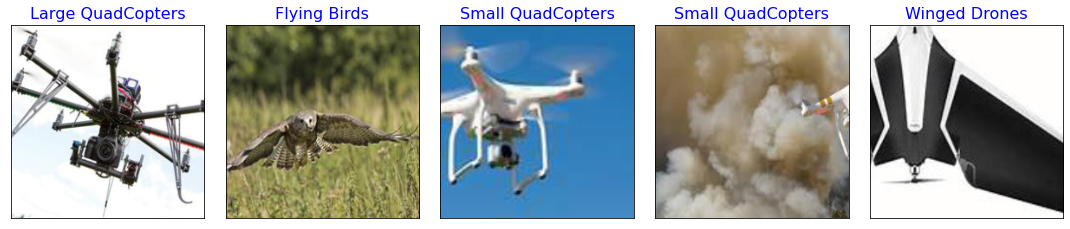

In [24]:
data.show_batch(save_as="sample.jpg")

# 4. Training Mobilenet Model - Only last layers
Modified last layer from 1000 classes to 4 and make only last layer trainable.
Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

In [7]:
import torch.optim as optim
#from torch_lr_finder import LRFinder

model_ft = models.mobilenet_v2(pretrained=True)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

for param in model_ft.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_ft.classifier[1] = nn.Linear(1280, 4)
model_ft = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


Find hyper parameter lr value using LR Finder

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


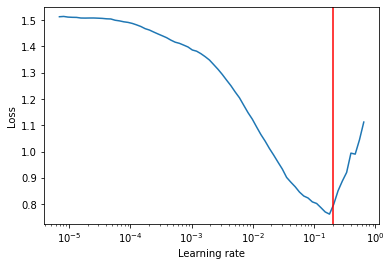

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.classifier[1].parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model_ft, optimizer, criterion, device="cuda")
lr_finder.range_test(data.dataloaders['train'], end_lr=10, num_iter=100)
lr_finder.plot(show_lr=0.2) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [9]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.classifier[1].parameters(), lr=0.9, momentum=0.09)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr=0.1, 
                                          steps_per_epoch=len(data.dataloaders['train']), #Training folder size/bs 
                                          epochs=25)

In [10]:
model_res, plotData = train_model(model_ft, data, device, criterion, optimizer_ft, scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.8135 Acc: 0.7214
val Loss: 0.4903 Acc: 0.8684

Epoch 1/24
----------
train Loss: 0.5326 Acc: 0.8289
val Loss: 0.3929 Acc: 0.8743

Epoch 2/24
----------
train Loss: 0.4693 Acc: 0.8411
val Loss: 0.3508 Acc: 0.8842

Epoch 3/24
----------
train Loss: 0.4375 Acc: 0.8486
val Loss: 0.3282 Acc: 0.8911

Epoch 4/24
----------
train Loss: 0.4218 Acc: 0.8516
val Loss: 0.3079 Acc: 0.8954

Epoch 5/24
----------
train Loss: 0.4090 Acc: 0.8505
val Loss: 0.3037 Acc: 0.8896

Epoch 6/24
----------
train Loss: 0.3976 Acc: 0.8597
val Loss: 0.3069 Acc: 0.8882

Epoch 7/24
----------
train Loss: 0.4057 Acc: 0.8508
val Loss: 0.2892 Acc: 0.8940

Epoch 8/24
----------
train Loss: 0.3856 Acc: 0.8560
val Loss: 0.2898 Acc: 0.8996

Epoch 9/24
----------
train Loss: 0.3875 Acc: 0.8585
val Loss: 0.2833 Acc: 0.9011

Epoch 10/24
----------
train Loss: 0.3726 Acc: 0.8637
val Loss: 0.2739 Acc: 0.9019

Epoch 11/24
----------
train Loss: 0.3740 Acc: 0.8644
val Loss: 0.2906 Acc: 0.8990

Epoch 12/24
----------
t

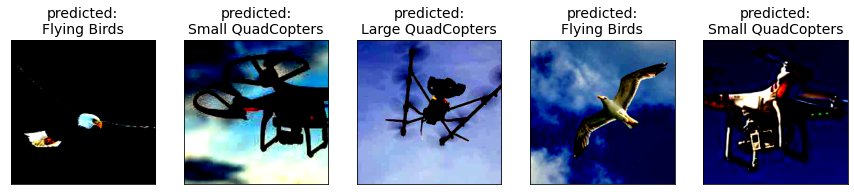

In [11]:
visualize_model(model_res, data, device,"visualize_1.jpg")

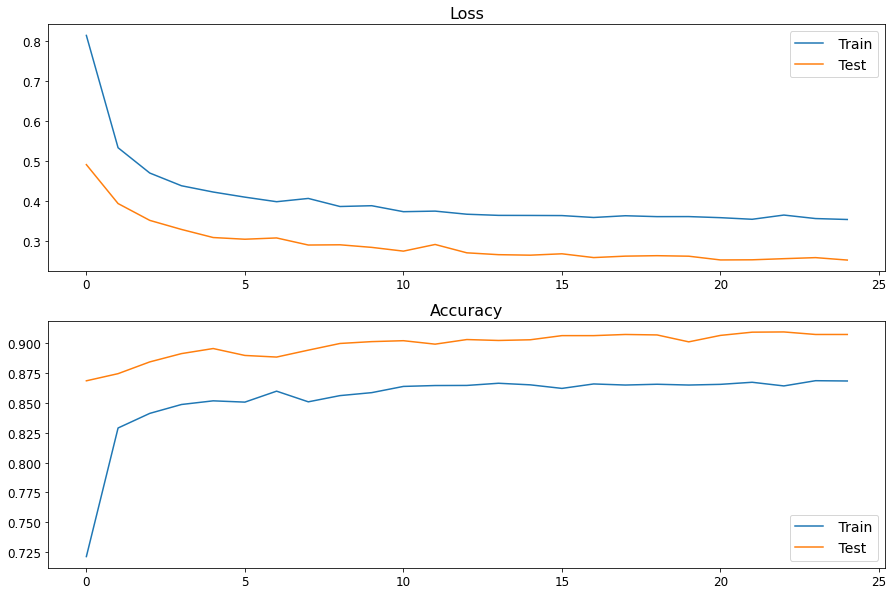

In [12]:
PlotGraph(plotData,"loss_accuracy_1.jpg")

#6. Finetuning the Model by Training all layers
Load a trained model and unfreeze all the layers. Train again to improve the accuracy. 

In [13]:
model_conv = model_res
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

model_conv = model_conv.to(device)

for param in model_conv.parameters():
    param.requires_grad = True

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


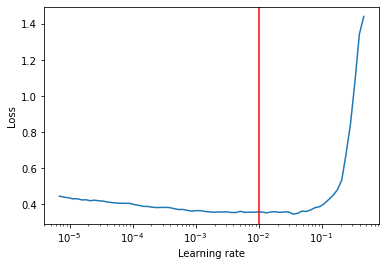

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_conv.parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model_conv, optimizer, criterion, device="cuda")
lr_finder.range_test(data.dataloaders['train'], end_lr=10, num_iter=100)
lr_finder.plot(show_lr=0.01) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [15]:
# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9,nesterov=True, weight_decay=1e-4)

# One Cycle Policy
scheduler = optim.lr_scheduler.OneCycleLR(optimizer_conv,
                                          max_lr=0.01, 
                                          steps_per_epoch=len(data.dataloaders['train']), #Training folder size/bs
                                          epochs=30,pct_start=0.2, div_factor=10, final_div_factor=100)

In [16]:
model_final, plotData = train_model(model_conv, data, device, criterion, optimizer_conv, scheduler,
                       num_epochs=30)

Epoch 0/29
----------
train Loss: 0.3237 Acc: 0.8781
val Loss: 0.2078 Acc: 0.9233

Epoch 1/29
----------
train Loss: 0.2622 Acc: 0.8986
val Loss: 0.2041 Acc: 0.9287

Epoch 2/29
----------
train Loss: 0.2369 Acc: 0.9126
val Loss: 0.1898 Acc: 0.9285

Epoch 3/29
----------
train Loss: 0.2388 Acc: 0.9108
val Loss: 0.2736 Acc: 0.9027

Epoch 4/29
----------
train Loss: 0.2487 Acc: 0.9059
val Loss: 0.1681 Acc: 0.9437

Epoch 5/29
----------
train Loss: 0.2121 Acc: 0.9197
val Loss: 0.1670 Acc: 0.9420

Epoch 6/29
----------
train Loss: 0.1999 Acc: 0.9257
val Loss: 0.1787 Acc: 0.9385

Epoch 7/29
----------
train Loss: 0.1918 Acc: 0.9268
val Loss: 0.2147 Acc: 0.9299

Epoch 8/29
----------
train Loss: 0.1772 Acc: 0.9342
val Loss: 0.2031 Acc: 0.9337

Epoch 9/29
----------
train Loss: 0.1741 Acc: 0.9352
val Loss: 0.1812 Acc: 0.9403

Epoch 10/29
----------
train Loss: 0.1719 Acc: 0.9358
val Loss: 0.2821 Acc: 0.8932

Epoch 11/29
----------
train Loss: 0.1860 Acc: 0.9319
val Loss: 0.2008 Acc: 0.9327

Ep

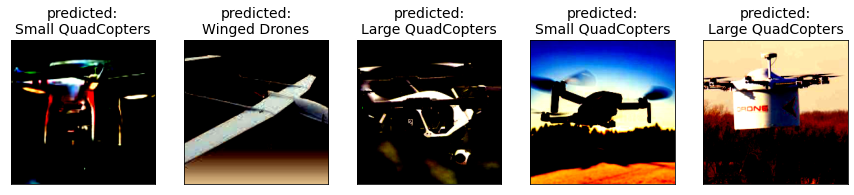

In [17]:
visualize_model(model_res, data, device,"visualize_2.jpg")
plt.ioff()
plt.show()

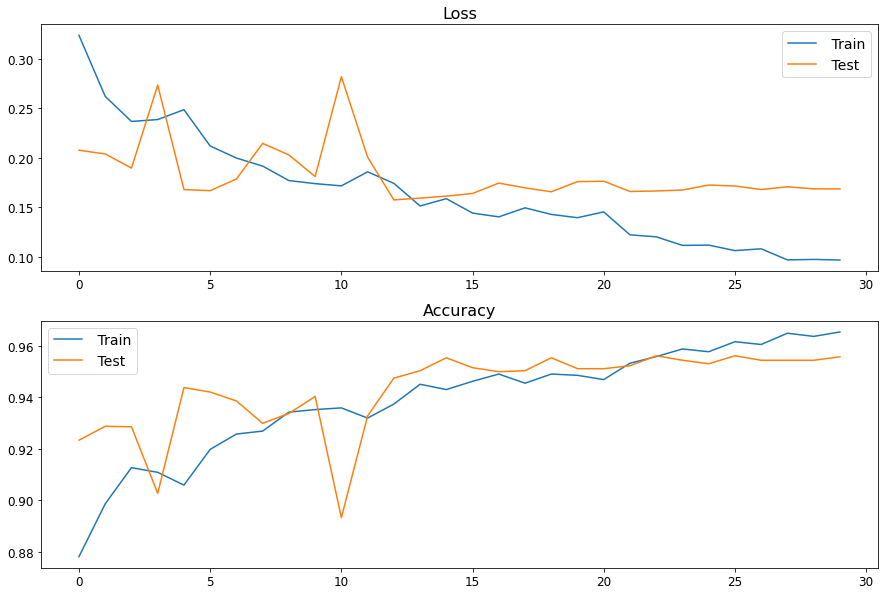

In [18]:
PlotGraph(plotData,"loss_accuracy_2.jpg")

# 7. Plotting Misclassified images

Miss-Classified Images in Flying Birds


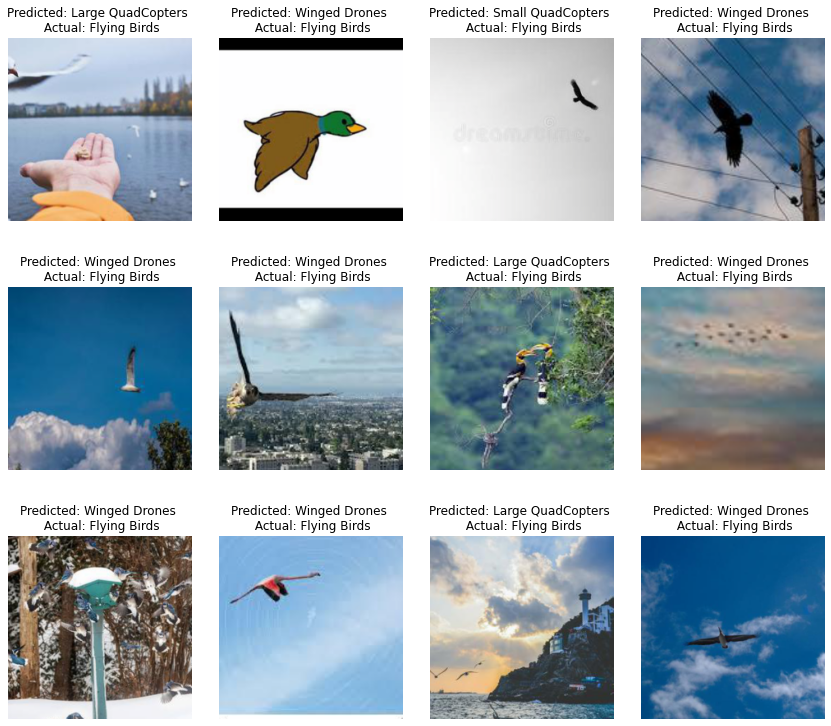

In [19]:
print("Miss-Classified Images in Flying Birds")
ShowMissclassifiedImages(model_final, data,0, device,save_as="MisclassifiedFlyingBirds.jpg")

Miss-Classified Images in Large Quadcopters


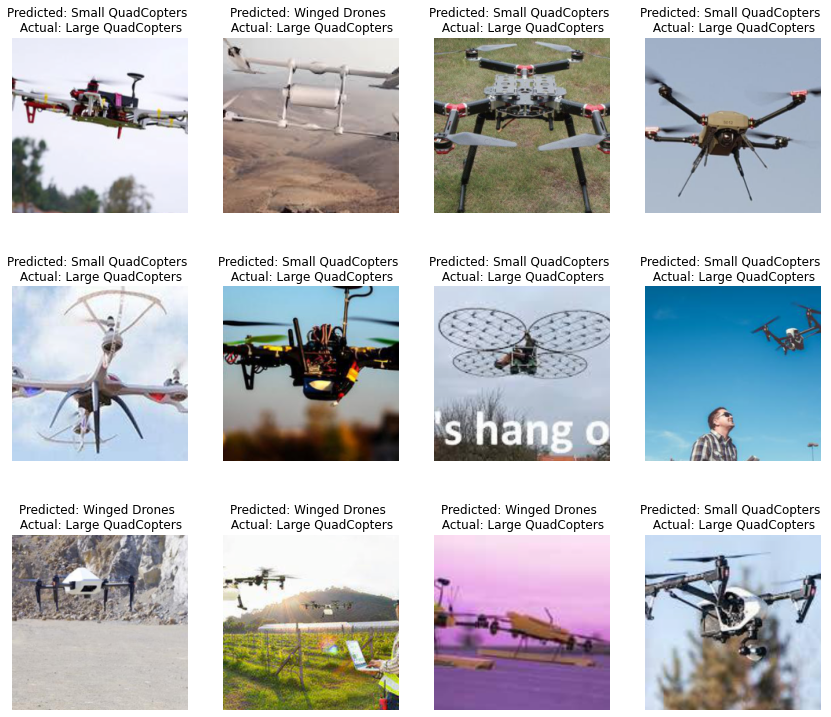

In [20]:
print("Miss-Classified Images in Large Quadcopters")
ShowMissclassifiedImages(model_final, data,1, device,save_as="MisclassifiedLargeQuadcopter.jpg")

Miss-Classified Images in Small Quadcopters


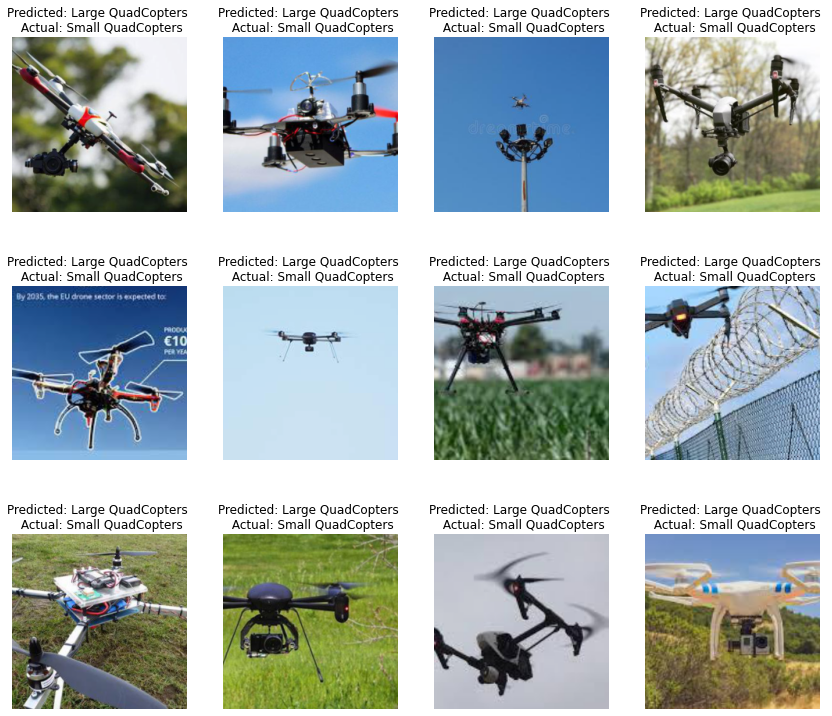

In [21]:
print("Miss-Classified Images in Small Quadcopters")
ShowMissclassifiedImages(model_final, data,2, device,save_as="MisclassifiedSmallQuadcopter.jpg")

Miss-Classified Images in Winged Drones


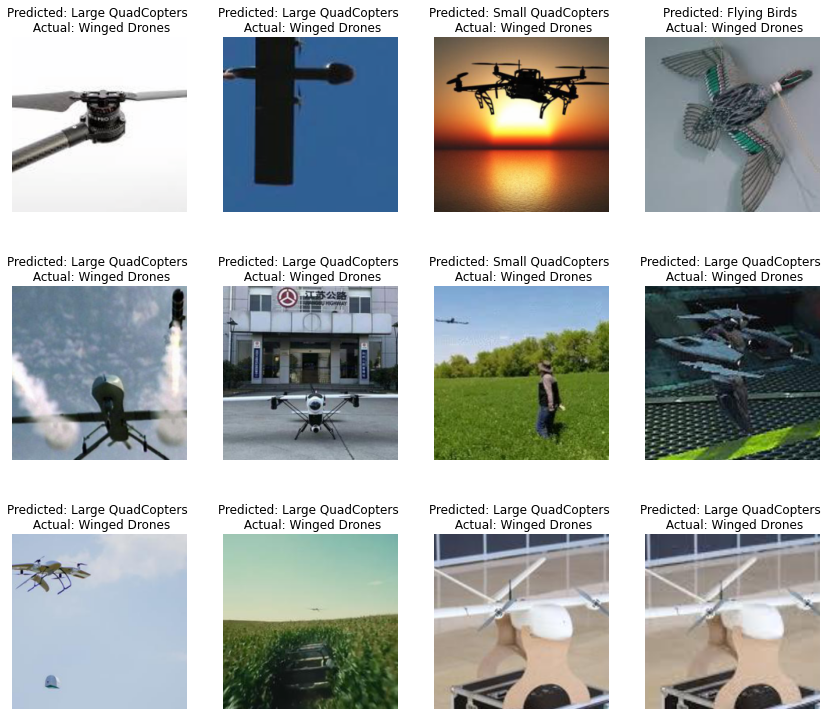

In [22]:
print("Miss-Classified Images in Winged Drones")
ShowMissclassifiedImages(model_final, data,3, device,save_as="MisclassifiedWingedDrones.jpg")

# 8. Saving Model

In [23]:
# Save GPU Model
torch.save(model_final.state_dict(), '/content/mobilenet_v2_custom_trained_gpu_v6.pt')

# Load CPU Model
device = torch.device('cpu')
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = nn.Linear(1280, 4)
model.load_state_dict(torch.load('/content/mobilenet_v2_custom_trained_gpu_v6.pt',
                                 map_location=device))

# Saving Trace Model
model.eval()
# trace model with a dummy input
traced_model = torch.jit.trace(model, torch.randn(1, 3, 224, 224))
traced_model.save('mobilenet_v2_custom_trained_v6.pt')